# Linear first order differential equation

In this toy example, we consider a first order linear differential equation, $\forall t\in[0, T]$, $a\in\mathbb{R}$,

$$
 \frac{d x(t)}{dt} = a x(t)
$$

with initial condition $x(t_0) = x_0$ true solution $x^\star(t) = x_0 e^{a(t -t_0)} $. It is frequent to work with the logarithmic form of the ODE for stability,

$$
\frac{d u(t)}{dt}=a,
$$
where $u(t)=\log x(t), \forall t.$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import our package

In [2]:
import jinns

Import other dependencies

In [3]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx

import matplotlib.pyplot as plt

figsize = (4, 4)
plt.rcParams["figure.figsize"] = figsize

key = random.PRNGKey(2)
key, subkey = random.split(key)

W1215 10:46:35.512247   23684 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1215 10:46:35.515587   23581 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Create the neural network architecture for the PINN with `equinox`.

In [4]:
eqx_list = (
    (eqx.nn.Linear, 1, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 1),
    # (jnp.exp,)
)
key, subkey = random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="ODE"
)

Create a DataGenerator object

In [5]:
nt = 320
batch_size = 32
method = "uniform"
tmin = 0
tmax = 1

Tmax = 1
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(
    key=subkey,
    nt=nt,
    tmin=tmin,
    tmax=tmax,
    temporal_batch_size=batch_size,
    method=method,
)

### Model parameters




In [6]:
# initial conditions and growth
t0 = 0
x0 = 1.0
a = 1.0

In [7]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={"a": a},
)

Visualize the output of the neural networks before the parameter learning step

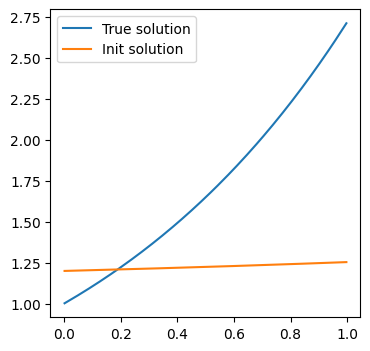

In [9]:
vectorized_u_init = vmap(lambda t: u(t, init_params), (0), 0)


def x_true(t):
    return x0 * jnp.exp(a * (t - t0))


ts = train_data.times.sort(axis=0)
plt.plot(ts * Tmax, vmap(x_true, 0)(ts * Tmax), label="True solution")
plt.plot(ts * Tmax, jnp.exp(vectorized_u_init(ts)), label="Init solution")
plt.legend()

## Loss construction

In [10]:
from jinns.loss import ODE


class LinearFODE(ODE):
    def equation(self, t, u, params):
        # in log-space
        u_ = lambda t, p: u(t, p)[0]
        du_dt = jax.grad(u_, 0)(t, params)
        return du_dt - self.Tmax * params.eq_params.a


fo_loss = LinearFODE(Tmax=Tmax)

In [11]:
loss_weights = jinns.loss.LossWeightsODE(dyn_loss=1.0, initial_condition=1.0)

loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fo_loss,
    initial_condition=(float(tmin), jnp.log(x0)),
    params=init_params,
)

In [12]:
# Testing the loss function
train_data, batch = train_data.get_batch()

losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(init_params, batch)
l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 0.9469279050827026
Individual losses: {'dyn_loss': '0.91', 'initial_condition': '0.03'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [13]:
params = init_params

In [14]:
# Optimizer
import optax

tx = optax.adam(learning_rate=1e-4)

In [15]:
n_iter = int(10000)

In [16]:
key, subkey = random.split(key)

In [17]:
params, total_loss_list, loss_by_term_dict, data, loss, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=params, data=train_data, optimizer=tx, loss=loss, n_iter=n_iter
    )
)

Initialization time: 0.8633372783660889

Compilation took
 2.7282800674438477 

[train] Iteration 0: loss value = 0.9461795091629028
[train] Iteration 1000: loss value = 0.0018060720758512616
[train] Iteration 2000: loss value = 0.0011530382325872779
[train] Iteration 3000: loss value = 0.0005120157147757709
[train] Iteration 4000: loss value = 7.943221862660721e-05
[train] Iteration 5000: loss value = 1.9334533135406673e-05
[train] Iteration 6000: loss value = 2.9366921808104962e-05
[train] Iteration 7000: loss value = 3.407004987820983e-05
[train] Iteration 8000: loss value = 1.0900207598751877e-05
[train] Iteration 9000: loss value = 1.7845699403551407e-05

Stopping main optimization loop, cause: max iteration is reached

Training took
 3.0484097003936768 


Final iteration 10000: train loss value = 6.063824912416749e-06


## Results

Plot the loss values

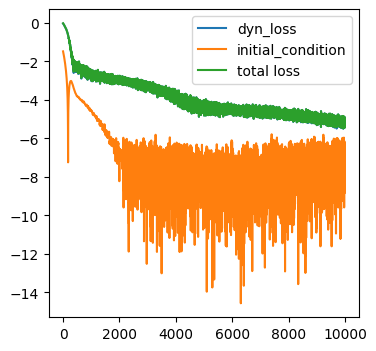

In [18]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show()

Plot the ODE solutions learned by the PINN

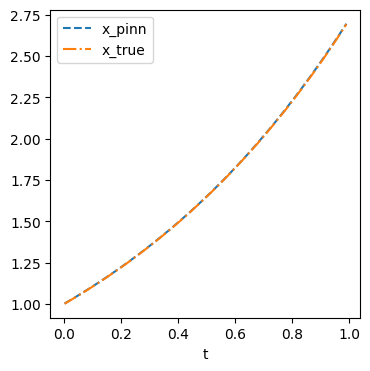

In [21]:
import pandas as pd

u_est = vmap(lambda t: u(t, params), (0), 0)


key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(
    key=subkey, nt=nt, tmin=tmin, tmax=tmax, method=method, temporal_batch_size=None
)

ts = val_data.times.sort(axis=0).squeeze()
df = pd.DataFrame(
    {
        "t": ts * Tmax,  # rescale time for plotting
        "x_pinn": jnp.exp(u_est(ts).squeeze()),
        "x_true": vmap(x_true)(ts),
        "Method": "PINN",
    },
)
df.plot(x="t", style=["--", "-."])
plt.show()